In [43]:
using Knet
using CUDA
using Images
using MLDatasets: MNIST
using FileIO, JLD2
import YAML

include("utils/common.jl")
include("src/networks.jl")

In [44]:
function discriminator_loss(G::DCGenerator,D::DCDiscriminator,x,y_real,y_fake,z,batch_size)
    fake = G(z)
    
    pred_real = D(x)
    pred_real = reshape(pred_real, batch_size)
    pred_fake = D(fake)
    pred_fake = reshape(pred_fake, batch_size)
    
    loss_real = bce(pred_real, y_real)
    loss_fake = bce(pred_fake, y_fake)
    loss_d = loss_real + loss_fake
    return loss_d
end

function generator_loss(G::DCGenerator,D::DCDiscriminator,x,y_real,z,batch_size)
    fake = G(z)
    
    pred_fake = D(fake)
    pred_fake = reshape(pred_fake, batch_size)
    
    loss_g = bce(pred_fake, y_real)
    return loss_g
end

generator_loss (generic function with 1 method)

In [45]:
function train_epoch_adv(generator::DCGenerator,discriminator::DCDiscriminator,dtrn, optimizer_d, optimizer_g,cfg)
    zdim = generator.zdim
    loss_d_value = 0.0
    loss_g_value = 0.0

    for (i,x) in enumerate(dtrn)
        batch_size = size(x)[end]
        x = reshape(x, (cfg["image_size"],cfg["image_size"],1,batch_size))
        y_real = CuArray(ones(Int32, batch_size))
        y_fake = CuArray(zeros(Int32, batch_size))
        
        # ------------ Training Discriminator ------------
        z = CuArray(randn(Float64, (1, 1, zdim, batch_size)))
        
        J_d = @diff discriminator_loss(generator, discriminator, x, y_real, y_fake, z, batch_size)
        for (j,p) in enumerate(params(discriminator))
            g = grad(J_d, p)
            update!(value(p), g, optimizer_d[j])
        end
        
        loss_d_val = value(J_d)
        # ------------ Training Generator ------------
        z = CuArray(randn(Float64, (1, 1, zdim, batch_size)))
        J_g = @diff generator_loss(generator, discriminator, x, y_real, z, batch_size)
        for (j,p) in enumerate(params(generator))
            g = grad(J_g, p)
            update!(value(p), g, optimizer_g[j])
        end
        
        loss_g_val = value(J_g)
        
        loss_d_value += loss_d_val * batch_size
        loss_g_value += loss_g_val * batch_size
    end
    loss_d_value /= dtrn.length
    loss_g_value /= dtrn.length
    return loss_d_value, loss_g_value
end

train_epoch_adv (generic function with 1 method)

In [46]:
function main()

    # ---------------- Configure ----------------
    cfg = YAML.load_file("configs/dcgan_asymmetric_two_stage_mnist.yml")

    # ---------------- Dataset ----------------
    xtrn, _ = MNIST.traindata(Float32);
    xtst, _ = MNIST.testdata(Float32);
    xtrn = imresize(xtrn, (cfg["image_size"],cfg["image_size"]))
    xtst = imresize(xtst, (cfg["image_size"],cfg["image_size"]))
    xtrn = normalize(xtrn)
    xtst = normalize(xtst)
    xtrn = permutedims(xtrn, (2,1,3))
    xtst = permutedims(xtst, (2,1,3))
    dtrn = minibatch(xtrn, cfg["batch_size"]; xtype = CuArray)
    dtst = minibatch(xtst, cfg["batch_size"]; xtype = CuArray)
    println("Data Summary:")
    println.(summary.((dtrn,dtst)));

    # ---------------- Network ----------------
    generator = DCGenerator(; zdim = cfg["zdim"], num_channels = cfg["num_channel"])
    discriminator = DCDiscriminator(; num_channels = cfg["num_channel"])


    # ---------------- Optimizer ----------------
    optimizer_g = init_optimizer(params(generator),cfg["optimizer_g"]["args"]["lr"],cfg["optimizer_g"]["args"]["betas"][1],cfg["optimizer_g"]["args"]["betas"][2]) #
    optimizer_d = init_optimizer(params(discriminator),cfg["optimizer_d"]["args"]["lr"],cfg["optimizer_d"]["args"]["betas"][1],cfg["optimizer_d"]["args"]["betas"][2]) # 

    # ---------------- Training ----------------
    zdim = cfg["zdim"]
    z_fix = CuArray(randn(Float64, (1, 1, zdim, 10)))
    
    println("Starting training...")
    for epoch in 1:cfg["num_epoch"]
        # Training
        loss_g, loss_d = train_epoch_adv(generator, discriminator, dtrn, optimizer_d, optimizer_g, cfg)
        println("Epoch: ", epoch)
        println("Loss D: ", loss_d)
        println("Loss G: ", loss_g)
        
        # Display generated images with a fixed z for each epoch
        fake_img = generator(z_fix)
        fake_img = Array(reshape(fake_img, (64,64 * 10)))
        fake_img = fake_img .* 0.5 .+ 0.5;
        display(Gray.(fake_img))
    end
    
    return generator, discriminator
end

main (generic function with 1 method)

In [ ]:
@time generator, discriminator = main();
@save "trained_models/generator.jld2" generator
@save "trained_models/discriminator.jld2" discriminator

Data Summary:
468-element Knet.Train20.Data{CuArray}
78-element Knet.Train20.Data{CuArray}
Starting training...


In [50]:
@load "trained_models/generator.jld2"

1-element Vector{Symbol}:
 :generator

In [49]:
cfg = YAML.load_file("configs/dcgan_asymmetric_two_stage_mnist.yml")
generator = DCGenerator(; zdim = cfg["zdim"], num_channels = cfg["num_channel"])

DCGenerator(100, 128, 1, Chain((ConvTranspose2d(P(CuArray{Float64, 4, CUDA.Mem.DeviceBuffer}(4,4,1024,100)), P(CuArray{Float64, 4, CUDA.Mem.DeviceBuffer}(1,1,1024,1)), 0, 1, 1), BatchNorm2d(Knet.Ops20.BNMoments(0.1, nothing, nothing, zeros, ones), P(CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}(2048)), true, 1.0e-5), Relu(0), ConvTranspose2d(P(CuArray{Float64, 4, CUDA.Mem.DeviceBuffer}(4,4,512,1024)), P(CuArray{Float64, 4, CUDA.Mem.DeviceBuffer}(1,1,512,1)), 1, 2, 1), BatchNorm2d(Knet.Ops20.BNMoments(0.1, nothing, nothing, zeros, ones), P(CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}(1024)), true, 1.0e-5), Relu(0), ConvTranspose2d(P(CuArray{Float64, 4, CUDA.Mem.DeviceBuffer}(4,4,256,512)), P(CuArray{Float64, 4, CUDA.Mem.DeviceBuffer}(1,1,256,1)), 1, 2, 1), BatchNorm2d(Knet.Ops20.BNMoments(0.1, nothing, nothing, zeros, ones), P(CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}(512)), true, 1.0e-5), Relu(0), ConvTranspose2d(P(CuArray{Float64, 4, CUDA.Mem.DeviceBuffer}(4,4,128,256)), P(CuArray{Float64

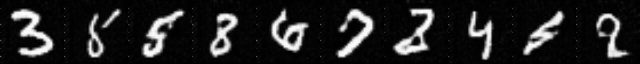

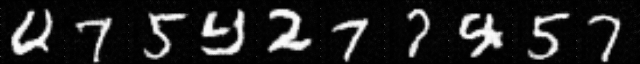

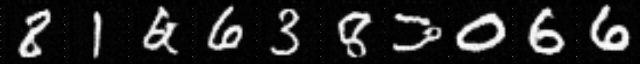

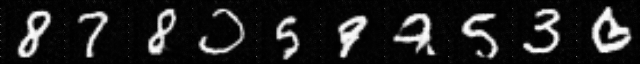

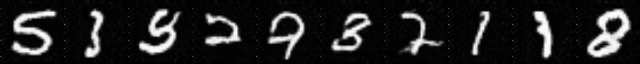

In [55]:
for i=1:5
    z = CuArray(randn(Float64, (1, 1, 100, 10)))
    fake_img = generator(z)
    fake_img = reshape(fake_img, (64,64 * 10))
    fake_img = Array(fake_img)
    fake_img = fake_img .* 0.5 .+ 0.5;
    display(Gray.(fake_img))
end

In [83]:
cfg = YAML.load_file("configs/dcgan_asymmetric_two_stage_mnist.yml")
xtrn, _ = MNIST.traindata(Float32);
xtst, _ = MNIST.testdata(Float32);
xtrn = imresize(xtrn, (64,64))
xtst = imresize(xtst, (64,64))
xtrn = normalize(xtrn)
xtst = normalize(xtst)
xtrn = permutedims(xtrn, (2,1,3))
xtst = permutedims(xtst, (2,1,3));

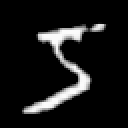

In [75]:
sample = xtrn[:,:,1]
Gray.(sample)